# Phase 1: OU Data Generation Diagnostics

**Goal:** Verify that the OU process generation is correct before testing the model.

## What We're Testing:
1. Visual inspection: Do trajectories show mean reversion?
2. Empirical vs theoretical statistics: Does the mean match theory?
3. Independence: Are dimensions uncorrelated?
4. Variance and autocorrelation: Do they follow OU theory?

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# OU params
theta_fixed = torch.tensor([[2.0, 0.0], [0.0, 1.5]], dtype=torch.float32)
mu = torch.tensor([0.0, 0.0], dtype=torch.float32)
sigma = torch.tensor([[0.3, 0.0], [0.0, 0.2]], dtype=torch.float32)
x0 = torch.tensor([1.5, 1.0], dtype=torch.float32)
dt = 0.1

print("OU Process Parameters:")
print(f"Θ (mean reversion rate):\n{theta_fixed}")
print(f"μ (long-term mean): {mu}")
print(f"Σ (diffusion): {sigma}")
print(f"x₀ (initial state): {x0}")
print(f"dt (time step): {dt}")

OU Process Parameters:
Θ (mean reversion rate):
tensor([[2.0000, 0.0000],
        [0.0000, 1.5000]])
μ (long-term mean): tensor([0., 0.])
Σ (diffusion): tensor([[0.3000, 0.0000],
        [0.0000, 0.2000]])
x₀ (initial state): tensor([1.5000, 1.0000])
dt (time step): 0.1


In [11]:
def generate_ou_data(theta, mu, sigma, x0, num_series=500, seq_len=100, dt=0.1):
    """Generate OU trajectories - same as your implementation"""
    data_dim = len(mu)
    all_series = []
    
    for _ in range(num_series):
        x = torch.zeros(seq_len, data_dim)
        x[0] = x0.clone()
        
        for t in range(1, seq_len):
            drift = -theta @ (x[t-1] - mu) * dt
            noise = sigma @ torch.randn(data_dim) * torch.sqrt(torch.tensor(dt))
            x[t] = x[t-1] + drift + noise
        
        all_series.append(x)
    
    return torch.stack(all_series)

#  test data
print("Generating OU data...")
num_series = 500
seq_len = 50
data = generate_ou_data(theta_fixed, mu, sigma, x0, num_series, seq_len, dt)
print(f"Generated data shape: {data.shape}  # (num_series, seq_len, data_dim)")

Generating OU data...
Generated data shape: torch.Size([500, 50, 2])  # (num_series, seq_len, data_dim)


## Visual Inspection

- Trajectories should start at [1.5, 1.0]
- Should show mean reversion toward [0, 0]
- Dimension 1 should decay faster (θ₁₁=2.0 > θ₂₂=1.5)
- No correlation between dimensions

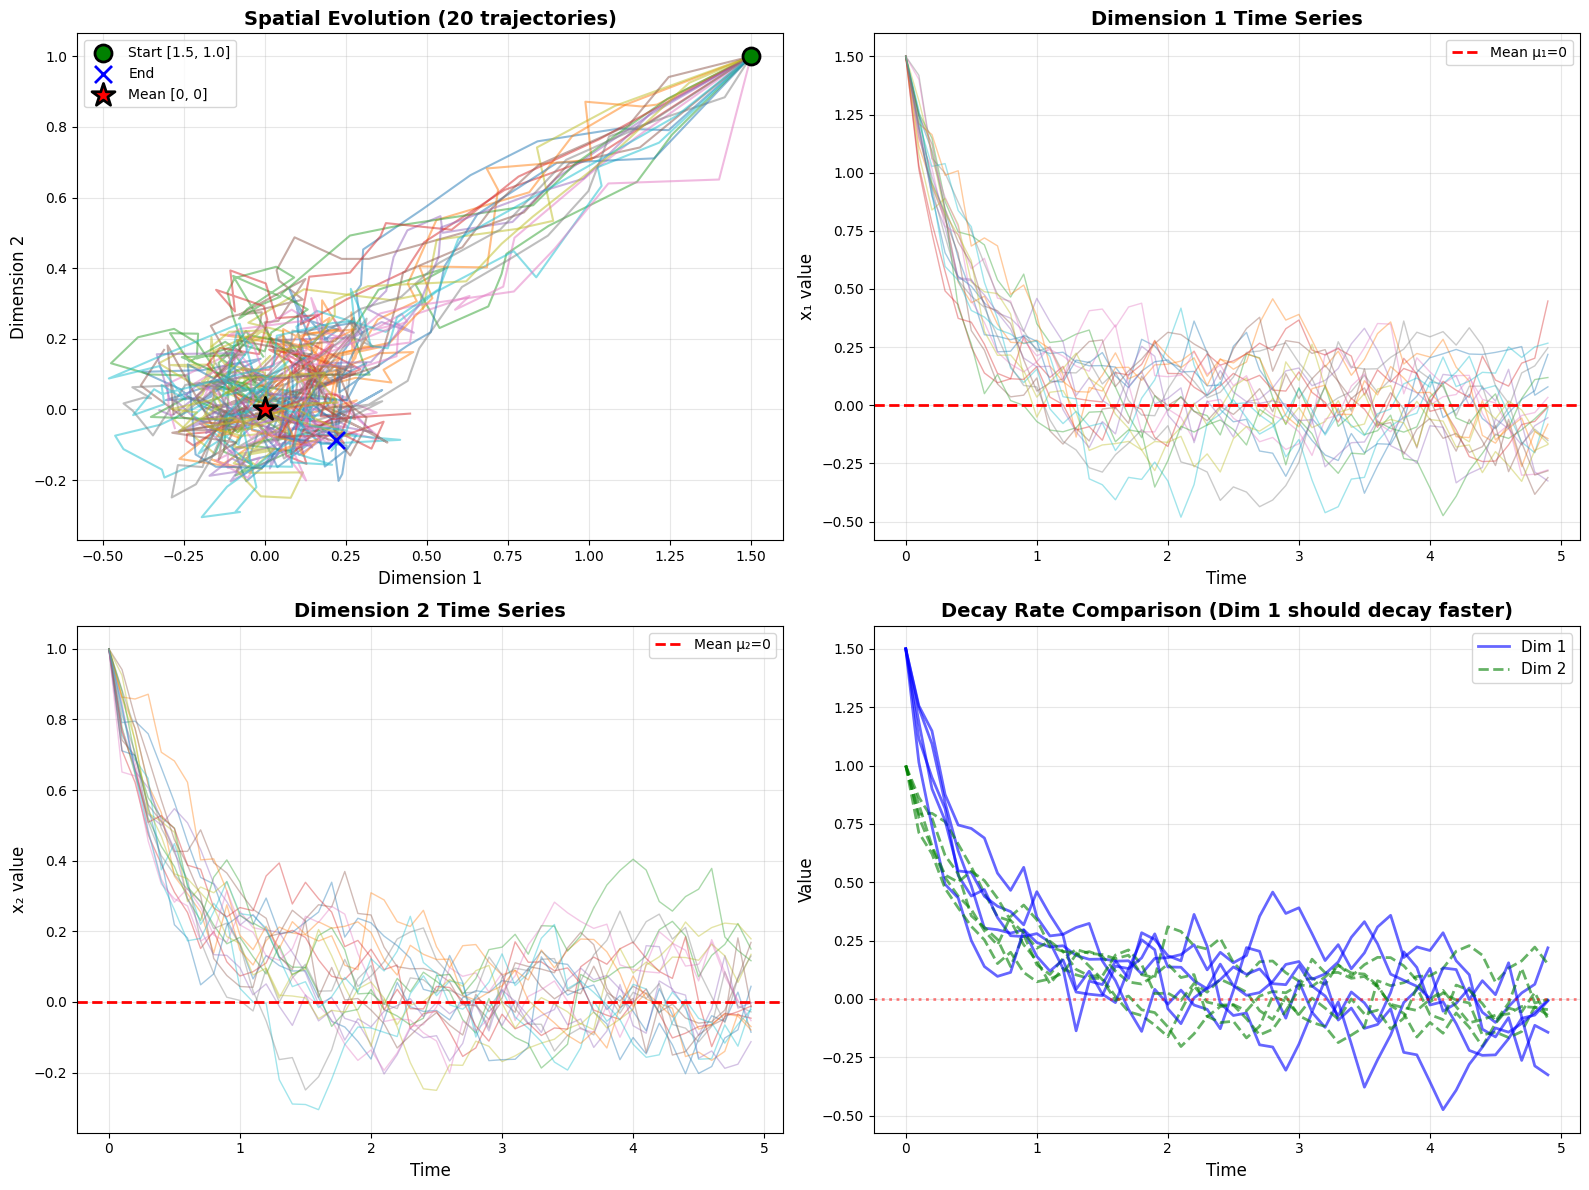

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Spatial view (x₁ vs x₂)
ax = axes[0, 0]
num_plot = 20
for i in range(num_plot):
    traj = data[i].numpy()
    ax.plot(traj[:, 0], traj[:, 1], alpha=0.5, linewidth=1.5)
    if i == 0:
        ax.scatter(traj[0, 0], traj[0, 1], s=150, c='green', marker='o', 
                  label='Start [1.5, 1.0]', zorder=5, edgecolors='black', linewidths=2)
        ax.scatter(traj[-1, 0], traj[-1, 1], s=150, c='blue', marker='x', 
                  label='End', zorder=5, linewidths=2)

ax.scatter(0, 0, s=300, c='red', marker='*', label='Mean [0, 0]', zorder=10, edgecolors='black', linewidths=2)
ax.set_xlabel('Dimension 1', fontsize=12)
ax.set_ylabel('Dimension 2', fontsize=12)
ax.set_title('Spatial Evolution (20 trajectories)', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Plot 2: Time series for dimension 1
ax = axes[0, 1]
time = np.arange(seq_len) * dt
for i in range(num_plot):
    traj = data[i].numpy()
    ax.plot(time, traj[:, 0], alpha=0.4, linewidth=1)

ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Mean μ₁=0')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('x₁ value', fontsize=12)
ax.set_title('Dimension 1 Time Series', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 3: tome series for dim 2
ax = axes[1, 0]
for i in range(num_plot):
    traj = data[i].numpy()
    ax.plot(time, traj[:, 1], alpha=0.4, linewidth=1)

ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Mean μ₂=0')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('x₂ value', fontsize=12)
ax.set_title('Dimension 2 Time Series', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

# Both dimensions overlaid (shows relative decay rates)
ax = axes[1, 1]
for i in range(5):  # Plot fewer for clarity
    traj = data[i].numpy()
    ax.plot(time, traj[:, 0], 'b-', alpha=0.6, linewidth=2, label='Dim 1' if i == 0 else '')
    ax.plot(time, traj[:, 1], 'g--', alpha=0.6, linewidth=2, label='Dim 2' if i == 0 else '')

ax.axhline(y=0, color='red', linestyle=':', linewidth=2, alpha=0.5)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Decay Rate Comparison (Dim 1 should decay faster)', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('test1_visual_inspection.png', dpi=150, bbox_inches='tight')
plt.show()


## Test 2: Empirical vs Theoretical Mean

**Theory:** For OU process with diagonal theta and mu=0:
- E[x₁(t)] = x₁(0) × exp(-θ₁₁ × t) = 1.5 × exp(-2.0 × t)
- E[x₂(t)] = x₂(0) × exp(-θ₂₂ × t) = 1.0 × exp(-1.5 × t)

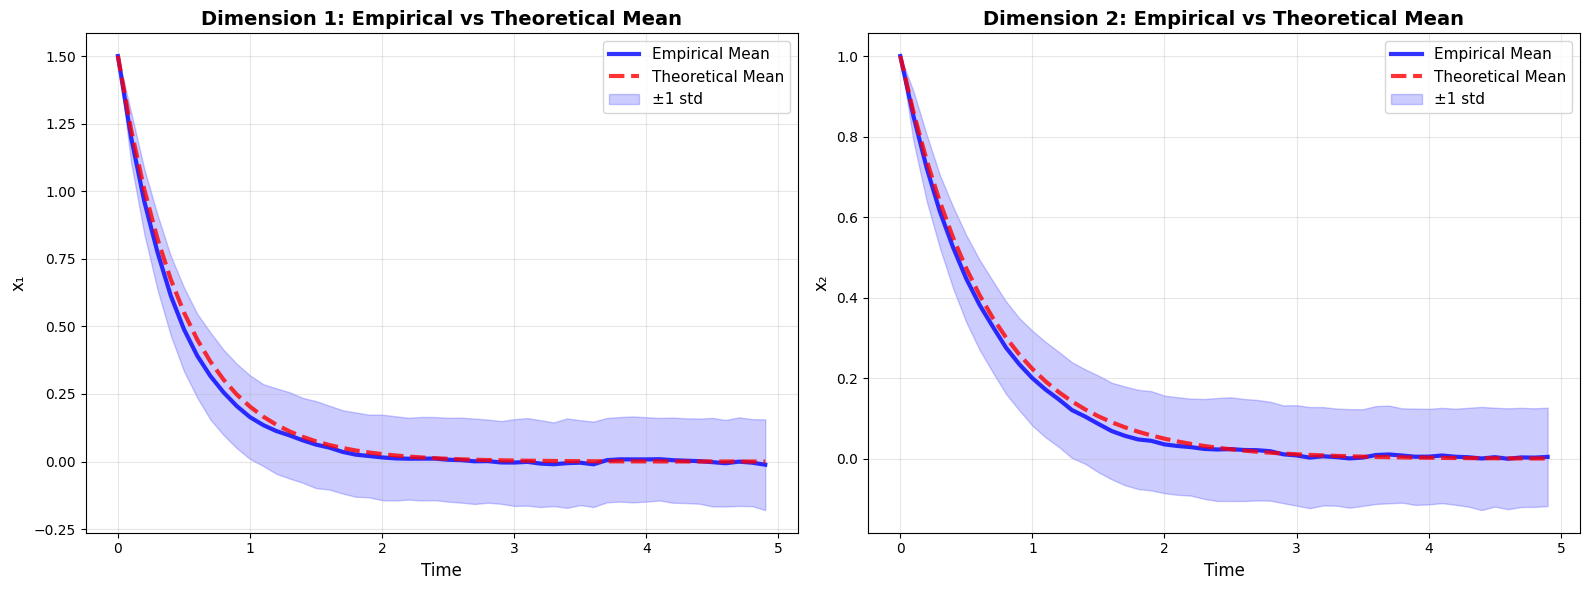

  t=0.0: Emp=[1.500, 1.000], Theory=[1.500, 1.000]
  t=1.0: Emp=[0.164, 0.200], Theory=[0.203, 0.223]
  t=2.0: Emp=[0.015, 0.036], Theory=[0.027, 0.050]
  t=3.0: Emp=[-0.004, 0.008], Theory=[0.004, 0.011]
  t=4.0: Emp=[0.008, 0.005], Theory=[0.001, 0.002]
  t=4.9: Emp=[-0.012, 0.005], Theory=[0.000, 0.001]

Empirical mean matches theoretical mean


In [12]:
# empirical mean across all trajectories
empirical_mean = data.mean(dim=0)  # Shape: (seq_len, 2)

# theoretical mean
time = np.arange(seq_len) * dt
theta_11 = theta_fixed[0, 0].item()
theta_22 = theta_fixed[1, 1].item()

theoretical_mean_1 = x0[0].item() * np.exp(-theta_11 * time)
theoretical_mean_2 = x0[1].item() * np.exp(-theta_22 * time)

# comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# dim 1
ax = axes[0]
ax.plot(time, empirical_mean[:, 0].numpy(), 'b-', linewidth=3, label='Empirical Mean', alpha=0.8)
ax.plot(time, theoretical_mean_1, 'r--', linewidth=3, label='Theoretical Mean', alpha=0.8)
ax.fill_between(time, 
                empirical_mean[:, 0].numpy() - data[:, :, 0].std(dim=0).numpy(),
                empirical_mean[:, 0].numpy() + data[:, :, 0].std(dim=0).numpy(),
                alpha=0.2, color='blue', label='±1 std')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('x₁', fontsize=12)
ax.set_title('Dimension 1: Empirical vs Theoretical Mean', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# dim 2
ax = axes[1]
ax.plot(time, empirical_mean[:, 1].numpy(), 'b-', linewidth=3, label='Empirical Mean', alpha=0.8)
ax.plot(time, theoretical_mean_2, 'r--', linewidth=3, label='Theoretical Mean', alpha=0.8)
ax.fill_between(time,
                empirical_mean[:, 1].numpy() - data[:, :, 1].std(dim=0).numpy(),
                empirical_mean[:, 1].numpy() + data[:, :, 1].std(dim=0).numpy(),
                alpha=0.2, color='blue', label='±1 std')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('x₂', fontsize=12)
ax.set_title('Dimension 2: Empirical vs Theoretical Mean', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('test2_empirical_vs_theoretical.png', dpi=150, bbox_inches='tight')
plt.show()

#  comparison
mse_dim1 = np.mean((empirical_mean[:, 0].numpy() - theoretical_mean_1)**2)
mse_dim2 = np.mean((empirical_mean[:, 1].numpy() - theoretical_mean_2)**2)


for t_idx in [0, 10, 20, 30, 40, 49]:
    t_val = time[t_idx]
    print(f"  t={t_val:.1f}: Emp=[{empirical_mean[t_idx, 0]:.3f}, {empirical_mean[t_idx, 1]:.3f}], "
          f"Theory=[{theoretical_mean_1[t_idx]:.3f}, {theoretical_mean_2[t_idx]:.3f}]")

if mse_dim1 < 0.01 and mse_dim2 < 0.01:
    print("\nEmpirical mean matches theoretical mean")
else:
    print("\nLarge deviation from theoretical mean!")